In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import datetime
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
## לא רלוונטי יותר היה חשוב ליצירת הדאטה
#df = pd.read_csv('no_show_original_data_2016.csv') #df = the original data from Kaggle

#df_wether= pd.read_csv('Wether_vitaria_2016.csv')
#df_wether.head()

#df_wether_all_day=pd.DataFrame

#df_wether_all_day=df_wether.groupby('date', as_index=False).agg({"prcp":"mean","temp":"mean"})
#df_wether_all_day['AppointmentDay'] = pd.to_datetime(df_wether_all_day['date'], format='%d-%m-%y')
#df_wether_all_day.head()

In [ ]:
##לא חשוב יותר-היה חשוב ליצירת הדאטה
##This will create a new column called ScheduledWeekDay = it converts the date to the day of the week.
#df['ScheduledDay'] = df['ScheduledDay'].astype('datetime64[ns]')
#df['ScheduledDay'][0].weekday()
#df.info()
#df['ScheduledWeekDay'] = df['ScheduledDay'].apply(lambda x: x.weekday()+1)

In [ ]:
## לא חשוב יותר היה רלוונטי ליצירת הדאטה
#df['AppointmentDay']=df['AppointmentDay'].astype(str).str[:-4].astype(np.datetime64)#לעשות רק פעם אחת! זה מעיף את השטויות מהתאריך ומשאיר אותו רק עם תאריך
#df['AppointmentDay']



In [ ]:
##לא חשוב יותר, היה רלוונטי ליצירת הדאטה 
#df
#df=df.merge(df_wether_all_day, how='left', on='AppointmentDay' )
#df=df.drop(['date'], axis=1)
#df.head()


In [ ]:
#df.to_csv('no_show_original_data_2016_with_update_weather')



In [ ]:
#df.isnull().sum()
# ניתן לראות של86016 רשומות אין משקעים ביום, כלומר רק לחמישית מהנתונים יש
#נכניס אפסים לכל המי שאין לו משקעים
#df = df.fillna(value = "0")
#df.isnull().sum()


In [ ]:
# משורה זו שואבים את הדאטה החדשה והרלוונטית
  
#df=pd.read_csv('no_show_original_data_2016_with_update_weather')
#df = df.drop(['Unnamed: 0'], axis=1)

### Adding another column that states the delta between ScheduledDay and AppointmentDay


In [ ]:
#df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
#df['ScheduledDay_date'] = df['ScheduledDay'].dt.date
#df['ScheduledDay_date'] = pd.to_datetime(df['ScheduledDay_date'])
#df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
#df['From_Schedualing_to_Appoitment'] = df['AppointmentDay']-df['ScheduledDay_date']
#df = df.drop('ScheduledDay', 1)

### adding a column of the day of the week of the appointment

In [ ]:
#df['AppointmentDay'] = df['AppointmentDay'].astype('datetime64[ns]')
#df['AppointmentDay'][0].weekday()
#df['Appointment_WeekDay'] = df['AppointmentDay'].apply(lambda x: x.weekday()+2)

### Droping the ScheduledWeekDay column

In [ ]:
#df = df.drop('ScheduledWeekDay', 1)

### changing the index (columns) order

In [ ]:
#new_index_order = ['PatientId', 'AppointmentID',  'Age', 'Gender', 'Neighbourhood', 'AppointmentDay', 'Appointment_WeekDay','From_Schedualing_to_Appoitment','prcp', 'temp', 
       #'Scholarship', 'Hipertension', 'Diabetes',
      # 'Alcoholism', 'Handcap', 'SMS_received',
     #  'ScheduledDay_date','No-show']
#df = df.reindex(columns=new_index_order)

In [ ]:
#df = pd.read_csv('no_show_original_data_2016_with_update_weather') #df = הדאטה אחרי שנוסף לו יום בשבוע, משקעים וטמפ' ממוצעים

In [ ]:
#df.to_csv('no_show_final_data')
#this is the data file we will until forther notice.

# START FROM HERE 
#### ALL OF THE ABOVE IS NOT RELEVANT ANYMORE

In [2]:
df=pd.read_csv('no_show_final_data')
df = df.drop(['Unnamed: 0'], axis=1)

#### Changing all the types correctly ####
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDay_date'] = pd.to_datetime(df['ScheduledDay_date'])
df['From_Schedualing_to_Appoitment'] = df['From_Schedualing_to_Appoitment'].str.replace('days 00:00:00.000000000', '')


In [3]:
# This will drop 5 rows unfortunately - otherwise I coulnd't change "From_Schedualing_to_Appoitment" to Int type.
#use this box only once. After the first time thers rows are gone so you can't rerun it.
df = df.drop([107953])
df = df.drop([56552])
df = df.drop([29635])
df = df.drop([34082])
df = df.drop([14205])

In [4]:
# changing object to int
df['From_Schedualing_to_Appoitment'] = df['From_Schedualing_to_Appoitment'].astype(int)

In [5]:
# creating codes for categorical variables.
df.loc[:, 'Neighbourhood_codes'] = df["Neighbourhood"].astype("category").cat.codes+1
df.loc[:, 'Gender_'] = df["Gender"].astype("category").cat.codes
#Woman=0, Man=1
df.loc[:, 'No-show_'] = df["No-show"].astype("category").cat.codes
#show=0, no-show=1 
change_index_order_again = ['PatientId', 'AppointmentID', 'Age', 'Gender', 'Gender_', 'Neighbourhood', 'Neighbourhood_codes',
       'AppointmentDay', 'Appointment_WeekDay',
       'From_Schedualing_to_Appoitment', 'prcp', 'temp', 'Scholarship',
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'ScheduledDay_date', 'No-show', 'No-show_']
df = df.reindex(columns = change_index_order_again)


In [6]:
#dfk = רק ילדים
#df = רק מבוגרים
#df_A_K =בנק של כולם, למתישהו
dfk=df
df_A_K=df

In [10]:
dfk = dfk[dfk.Age <=15] # מוריד כל מי שגדול 16

In [25]:
df = df[df.Age >15] #מוריד כל מי שקטן 16
# 86054 מבוגרים
# 24467 ילדים
# סה"כ = 110521
dfk.describe()


,PatientId,AppointmentID,Age,Gender_,Neighbourhood_codes,Appointment_WeekDay,From_Schedualing_to_Appoitment,prcp,temp,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show_
count,2.446700e+04,2.446700e+04,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000,24467.000000
mean,1.491595e+14,5.676458e+06,6.240324,0.511097,43.650631,3.840438,9.706666,0.249291,24.251166,0.106633,0.000981,0.000899,0.000695,0.008501,0.293906,0.214452
std,2.578165e+14,6.760575e+04,4.791649,0.499887,22.540870,1.376798,13.792120,0.902047,1.056043,0.308653,0.031305,0.029973,0.026351,0.111878,0.455559,0.410450
min,1.420000e+05,5.216818e+06,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,21.941667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.217150e+12,5.639710e+06,2.000000,0.000000,28.000000,3.000000,0.000000,0.000000,23.858333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.193270e+13,5.679845e+06,6.000000,1.000000,42.000000,4.000000,3.000000,0.000000,24.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.484310e+13,5.726028e+06,10.000000,1.000000,62.000000,5.000000,15.000000,0.000000,24.804167,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.999820e+14,5.790284e+06,15.000000,1.000000,81.000000,6.000000,146.000000,4.666667,26.300000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


### Numerical variables:
1. Age
2. prcp
3. temp
4. PatientId

### Categorical nominal variables: 

1. Neighbourhood_codes
2. Gender_
3. Scholarship
2. Hipertension
5. Diabetes
3. Alcoholism
4. Handcap
5. SMS_received

### Categorical ordinal variables: 

1. Appointment_WeekDay
2. AppointmentDay
3. From_Schedualing_to_Appoitment
4. ScheduledDay_date
5. AppointmentID

In [ ]:
#df_wether_all_day.head()

In [ ]:
len(df['Neighbourhood_codes'].value_counts())

In [ ]:
df["PatientId"].value_counts()

In [ ]:
df['AppointmentID'].value_counts().head()

In [ ]:
df['SMS_received'].value_counts().head()
# we can't know if there was more then 1 SMS sent. 

In [ ]:
df.describe()

In [ ]:
df.info()

### Analizing the data: first conclutions
1. There was 1 row with the age of (-1). It wasn't a no show, so I deleted it (Itamar).
2. The SMS column states if a text was sent or not. It does not state how many sms were sent.

In [12]:
df.isnull().sum()

PatientId                         0
AppointmentID                     0
Age                               0
Gender                            0
Gender_                           0
Neighbourhood                     0
Neighbourhood_codes               0
AppointmentDay                    0
Appointment_WeekDay               0
From_Schedualing_to_Appoitment    0
prcp                              0
temp                              0
Scholarship                       0
Hipertension                      0
Diabetes                          0
Alcoholism                        0
Handcap                           0
SMS_received                      0
ScheduledDay_date                 0
No-show                           0
No-show_                          0
dtype: int64

In [ ]:
sns.countplot(x='Gender', data=df)
# women go mnore to the doctor
# no differance between men and women in "no-show"s

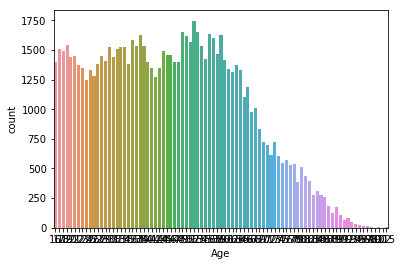

In [13]:
sns.countplot(x='Age', data=df)
# not normal distribution? what to do?

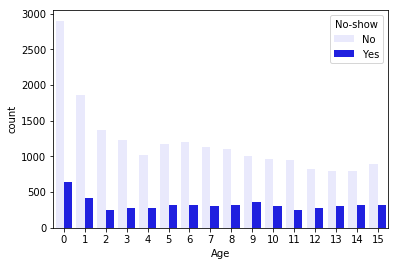

In [15]:
sns.countplot(x='Age', data=dfk,  color='blue',hue = 'No-show')
# not normal distribution? what to do?

In [ ]:
sns.countplot(x='Neighbourhood_codes', data=df, color='blue',hue = 'No-show')

In [ ]:
sns.countplot(x='Alcoholism', data=df, color='blue',hue = 'No-show')

In [ ]:
sns.countplot(x='From_Schedualing_to_Appoitment', data=df, color='blue',hue = 'No-show')

In [ ]:
sns.countplot(x='Appointment_WeekDay', data=df, color='blue',hue = 'No-show')

In [ ]:
sns.countplot(x='SMS_received', data=df, color='blue',hue = 'No-show')
# SMS did not help decrise the number of no-shows in the problematic patients.

In [ ]:
sns.countplot(x='prcp', data=df, color='blue',hue = 'No-show')
# SMS did not help decrise the number of no-shows in the problematic patients.

In [ ]:
sns.countplot(y='Scholarship', data=df, color='blue',hue = 'No-show')

In [ ]:
sns.countplot(y='Gender', data=df, color='blue',hue = 'No-show')

In [ ]:
sns.countplot(y='Gender', data=df, color='blue',hue = 'No-show')

In [ ]:
sns.countplot(x='From_Schedualing_to_Appoitment', data=df)
#how to make normal?

In [ ]:
sns.countplot(y='ScheduledWeekDay', data=df, color='blue',hue = 'No-show')
#no real information here - Monday has more no-shows but olso more appointments - 
#so.... hard to say if this says anything.

In [ ]:
df.sort_values('AppointmentDay')

In [ ]:
df['AppointmentDay'].value_counts()

In [ ]:
# Identify missing data
df.isnull().sum()
# no missing data :)

### making a pie chart

In [ ]:
fig1, ax1 = plt.subplots()

slices = df["Scholarship"].value_counts()
labels = slices.index
ax1.pie(slices, autopct='%1.1f%%', labels=labels)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()

slices = df["Alcoholism"].value_counts()
labels = slices.index
ax1.pie(slices, autopct='%1.1f%%', labels=labels)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

##### Encode ordinal feature
We can define a dictionary that maps each ordinal value to a numerical value, and then use the function "map" as shown below, or use the function "replace" as shown in: http://pbpython.com/categorical-encoding.html .

In [ ]:
sns.countplot(x='From_Schedualing_to_Appoitment', data=df)

##### #### 3.1 Histograms to view features

In [ ]:
df.columns

In [ ]:
df.hist(bins = 200, figsize = (20,15), column=['PatientId', 'AppointmentID', 'Age', 'Gender', 'Gender_',
       'Neighbourhood', 'Neighbourhood_codes', 'AppointmentDay',
       'Appointment_WeekDay', 'From_Schedualing_to_Appoitment', 'prcp', 'temp',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'ScheduledDay_date', 'No-show', 'No-show_']) #Check the hist parameters by clicking on the Tab completion. 
plt.show()

In [ ]:
sns.distplot(df["Age"], fit=norm)

In [ ]:
sns.distplot(df["prcp"], fit=norm)

In [ ]:
sns.distplot(df["Appointment_WeekDay"])


In [ ]:
#לא יודעים מה לעשות עם זה
#New_age = np.clip(df['Age'], 1, 95)
#plt.hist(df['Age'], bins=50)
#plt.hist(New_age, bins=50, color='red', alpha = 0.5)
#plt.show()

In [ ]:
sqrt_age = np.sqrt(df["Age"])

In [ ]:
sns.distplot(df["Age"], fit=norm)

In [ ]:
sns.distplot(log_age, fit=norm, bins=15)

In [20]:
train_df, test_df= train_test_split(df, test_size = 0.2, random_state=7)
# train_test_split is from sklearn. It requiers that the data will be a numpy array, that is numbers only.
# If your prediction class in y is very small, then add a parameter startify = y

In [27]:
train_df.describe()

,PatientId,AppointmentID,Age,Gender_,Neighbourhood_codes,Appointment_WeekDay,From_Schedualing_to_Appoitment,prcp,temp,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show_
count,6.884300e+04,6.884300e+04,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000,68843.000000
mean,1.460863e+14,5.674894e+06,45.875194,0.304577,42.475415,3.867859,10.344102,0.259342,24.235677,0.095347,0.252967,0.091876,0.038595,0.025987,0.329750,0.198364
std,2.548464e+14,7.223181e+04,18.237892,0.460231,22.286114,1.372253,15.644225,0.921054,1.045352,0.293696,0.434715,0.288853,0.192629,0.172922,0.470126,0.398771
min,3.920000e+04,5.030230e+06,16.000000,0.000000,1.000000,2.000000,0.000000,0.000000,21.941667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.165985e+12,5.640419e+06,31.000000,0.000000,26.000000,3.000000,0.000000,0.000000,23.858333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.149790e+13,5.680700e+06,45.000000,0.000000,40.000000,4.000000,4.000000,0.000000,24.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.378035e+13,5.725365e+06,59.000000,1.000000,61.000000,5.000000,15.000000,0.000000,24.804167,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.999690e+14,5.790484e+06,115.000000,1.000000,81.000000,7.000000,179.000000,4.666667,26.300000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [28]:
y = train_df["No-show_"]
X = train_df

In [31]:
len(df.columns)
[0:]

21

In [38]:
train_df_numeric = train_df.iloc[:, 0:20]
# iloc = integer-location based indexing for selection by position
corr_df=train_df_numeric.corr()
corr_df

,PatientId,AppointmentID,Age,Gender_,Neighbourhood_codes,Appointment_WeekDay,From_Schedualing_to_Appoitment,prcp,temp,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
PatientId,1.000000,0.000807,-0.003689,0.011260,0.004683,-0.000938,0.003031,0.001356,0.005275,0.000969,-0.006820,0.001199,0.011994,-0.003559,-0.006519
AppointmentID,0.000807,1.000000,-0.022907,0.025010,0.002786,-0.051003,-0.779173,-0.040578,0.043289,0.021905,0.018419,0.027832,0.038204,0.013368,-0.246798
Age,-0.003689,-0.022907,1.000000,0.036990,0.003358,-0.003383,0.037782,-0.009317,-0.004084,-0.143258,0.472810,0.272148,0.042202,0.064992,-0.017255
Gender_,0.011260,0.025010,0.036990,1.000000,-0.017714,0.008642,-0.034720,0.006540,0.001129,-0.146932,-0.009163,-0.003874,0.141360,0.034517,-0.054394
Neighbourhood_codes,0.004683,0.002786,0.003358,-0.017714,1.000000,-0.004515,-0.002411,-0.002902,-0.003853,0.004630,0.009161,0.016037,0.001986,0.012324,0.022656
Appointment_WeekDay,-0.000938,-0.051003,-0.003383,0.008642,-0.004515,1.000000,-0.014105,0.239549,-0.174185,-0.007664,0.002879,0.006735,0.002918,0.001494,-0.101127
From_Schedualing_to_Appoitment,0.003031,-0.779173,0.037782,-0.034720,-0.002411,-0.014105,1.000000,-0.012850,-0.009667,-0.028396,-0.024050,-0.033191,-0.042849,-0.019629,0.385494
prcp,0.001356,-0.040578,-0.009317,0.006540,-0.002902,0.239549,-0.012850,1.000000,0.166564,-0.003687,-0.003097,-0.004557,0.001806,-0.000422,-0.006581
temp,0.005275,0.043289,-0.004084,0.001129,-0.003853,-0.174185,-0.009667,0.166564,1.000000,-0.005984,-0.009694,-0.002680,-0.002740,-0.000909,-0.117233
Scholarship,0.000969,0.021905,-0.143258,-0.146932,0.004630,-0.007664,-0.028396,-0.003687,-0.005984,1.000000,-0.016437,-0.023813,0.044333,-0.009604,0.000581


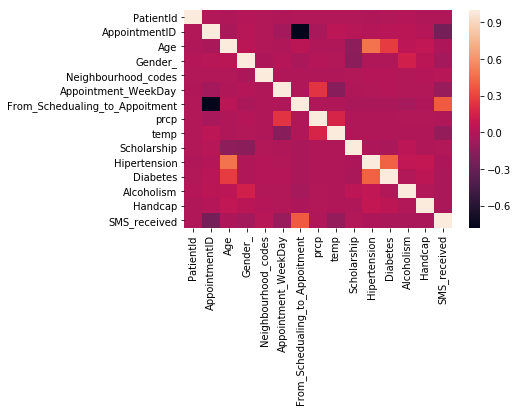

In [39]:
sns.heatmap(corr_df)
# corr of 47% > Age + Hypertention (blood pressure)
# corr of 27% > Age + Diabetes
# corr of 41% > Diabetes + Hypertention (blood pressure)
# corr of 38% > SMS + From_Schedualing_to_Appoitment

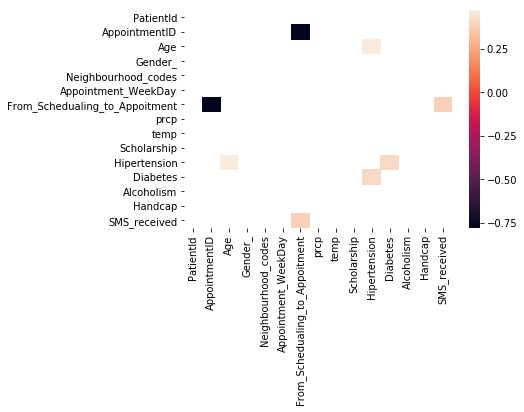

In [40]:
sns.heatmap(corr_df[(corr_df<1) & ((corr_df >= 0.3) | (corr_df <= -0.3)) ] )

In [42]:
corr_matrix = train_df.corr()
corr_matrix["No-show_"].sort_values()

AppointmentID                    -0.150026
Age                              -0.083190
Hipertension                     -0.035321
Diabetes                         -0.016225
Neighbourhood_codes              -0.010188
Handcap                          -0.008821
Gender_                          -0.008018
prcp                             -0.004494
Appointment_WeekDay              -0.004048
PatientId                         0.000200
Alcoholism                        0.002448
temp                              0.012896
Scholarship                       0.031123
SMS_received                      0.126603
From_Schedualing_to_Appoitment    0.170900
No-show_                          1.000000
Name: No-show_, dtype: float64